In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../..')

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import copy

from magrec.misc.plot import plot_n_components
from magrec.transformation.MagneticFields import MagneticFields   
from magrec.transformation.Bsensor2Mxy import Bsensor2Mxy   
from magrec.misc.data import Data
from magrec import __datapath__

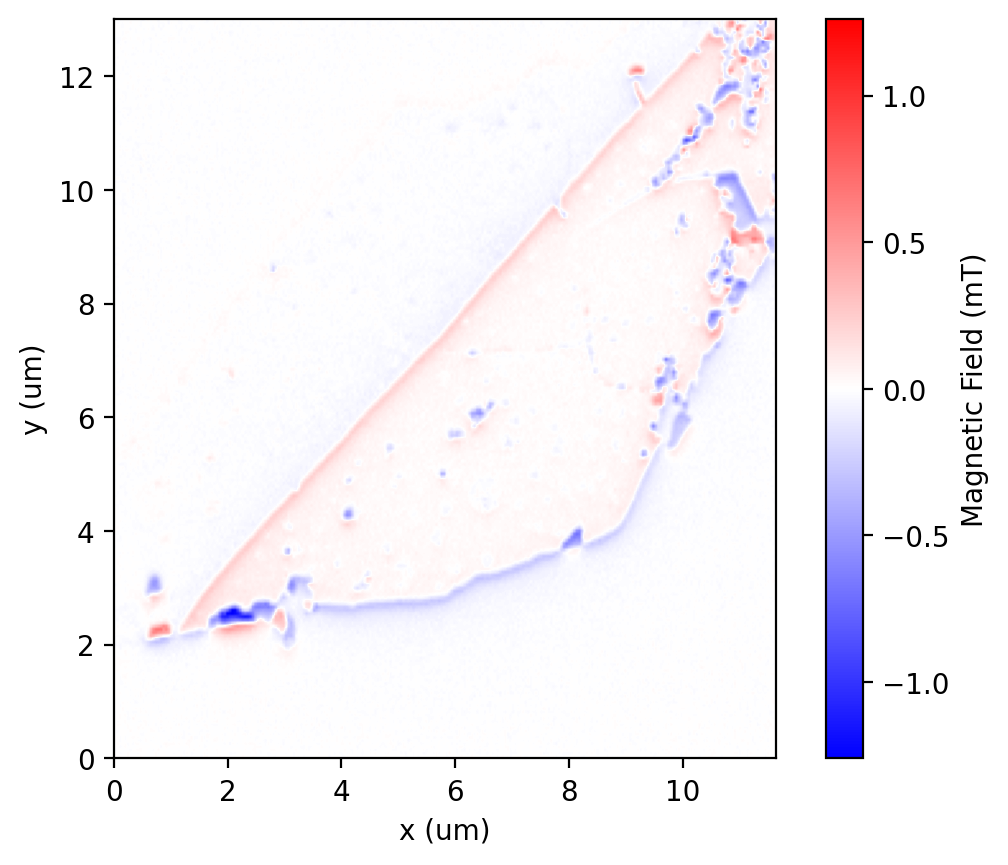

In [4]:
f = open(__datapath__ / "experimental" / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6

# dataset.define_pixel_size(dx, dy)

sensor_theta = 56
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

dataset = Data()
dataset.load_data(BNV, dx, dy, 0.05, sensor_theta, sensor_phi, 0)

dataset.remove_DC_background()
dataset.plot_target()


In [5]:
# Add filter 
dataset.add_hanning_filter(0.05)
dataset.add_hanning_filter(0.05)

[11, 244, 0, 256]


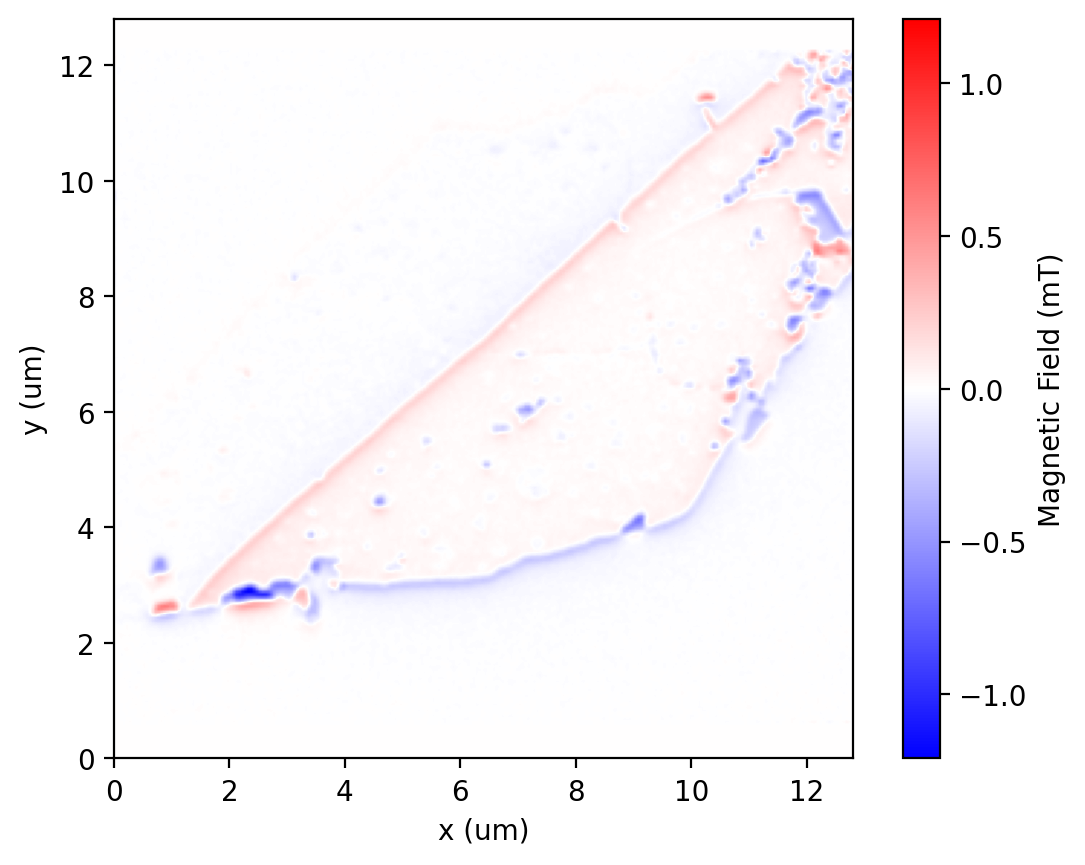

In [6]:
dataset.crop_data([0,256,0,256])
dataset.pad_data_to_power_of_two()
dataset.plot_target()

# Transfor Bsensor into Bxyz

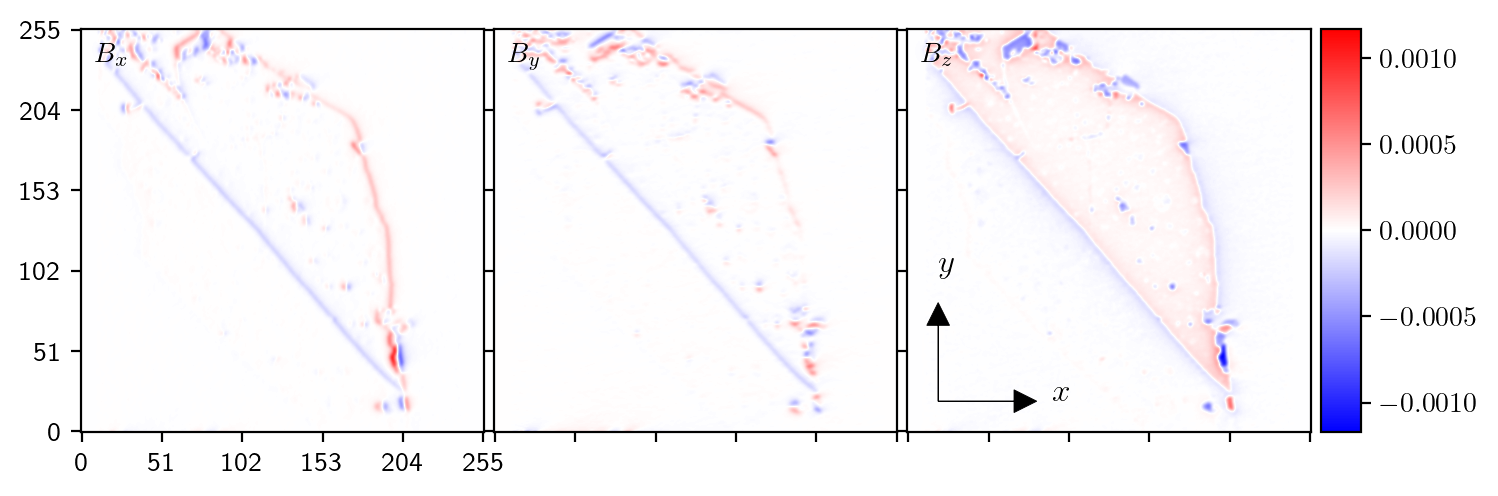

In [7]:
dataset.set_transformer(MagneticFields)
dataset.transform_data()

plot_n_components(dataset.transformed_target, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

## Now we will try to reconstruct the magnetisation using a neural network.

In [178]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMagnetisation import UniformMagnetisation

dataset4 = copy.deepcopy(dataset)
dataset4.target = dataset4.target*1e6

Model = UniformMagnetisation(dataset4, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = FCNN(Model, dataset4)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1
65536


In [179]:
FittingMethod.fit(n_epochs=150)

epoch     1 | loss on last mini-batch:  3.94e+03
epoch    11 | loss on last mini-batch:  3.94e+03
epoch    21 | loss on last mini-batch:  3.93e+03
epoch    31 | loss on last mini-batch:  3.65e+03
epoch    41 | loss on last mini-batch:  2.48e+03
epoch    51 | loss on last mini-batch:  1.31e+03
epoch    61 | loss on last mini-batch:  8.05e+02
epoch    71 | loss on last mini-batch:  4.46e+02
epoch    81 | loss on last mini-batch:  2.66e+02
epoch    91 | loss on last mini-batch:  1.67e+02
epoch   101 | loss on last mini-batch:  1.11e+02
epoch   111 | loss on last mini-batch:  7.85e+01
epoch   121 | loss on last mini-batch:  5.82e+01
epoch   131 | loss on last mini-batch:  4.45e+01
epoch   141 | loss on last mini-batch:  3.49e+01


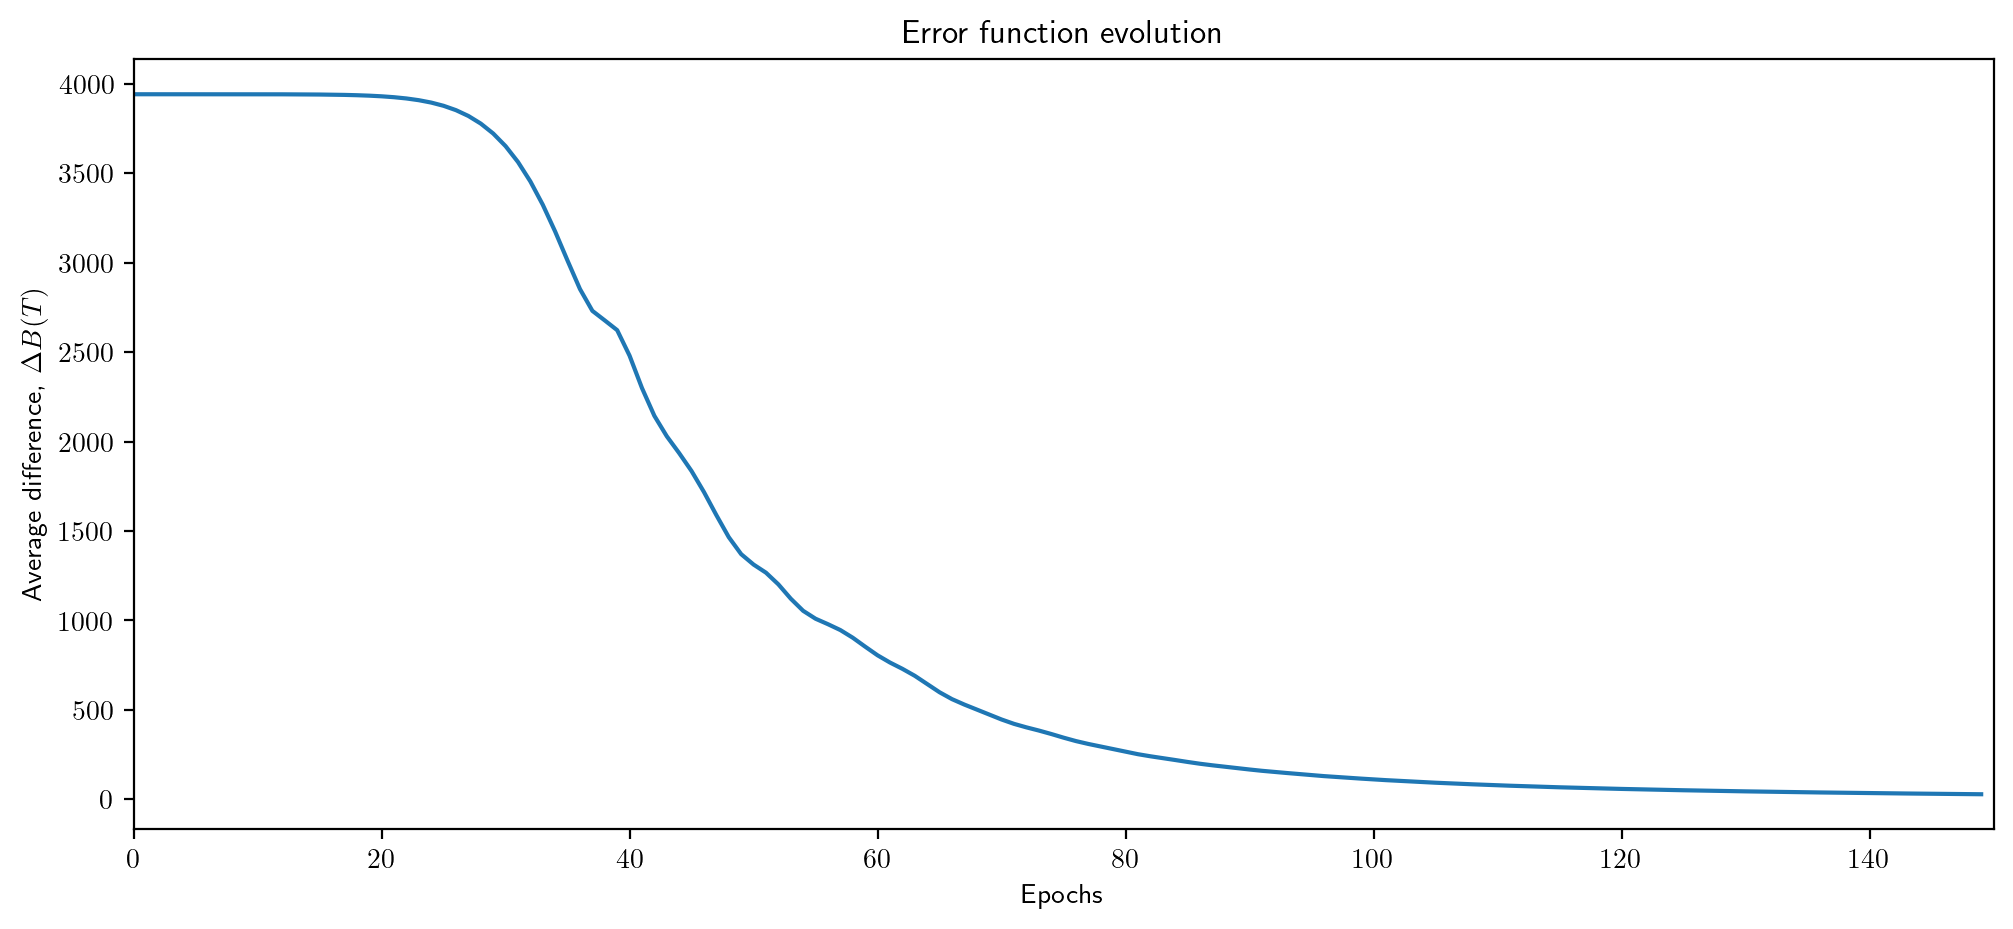

In [180]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


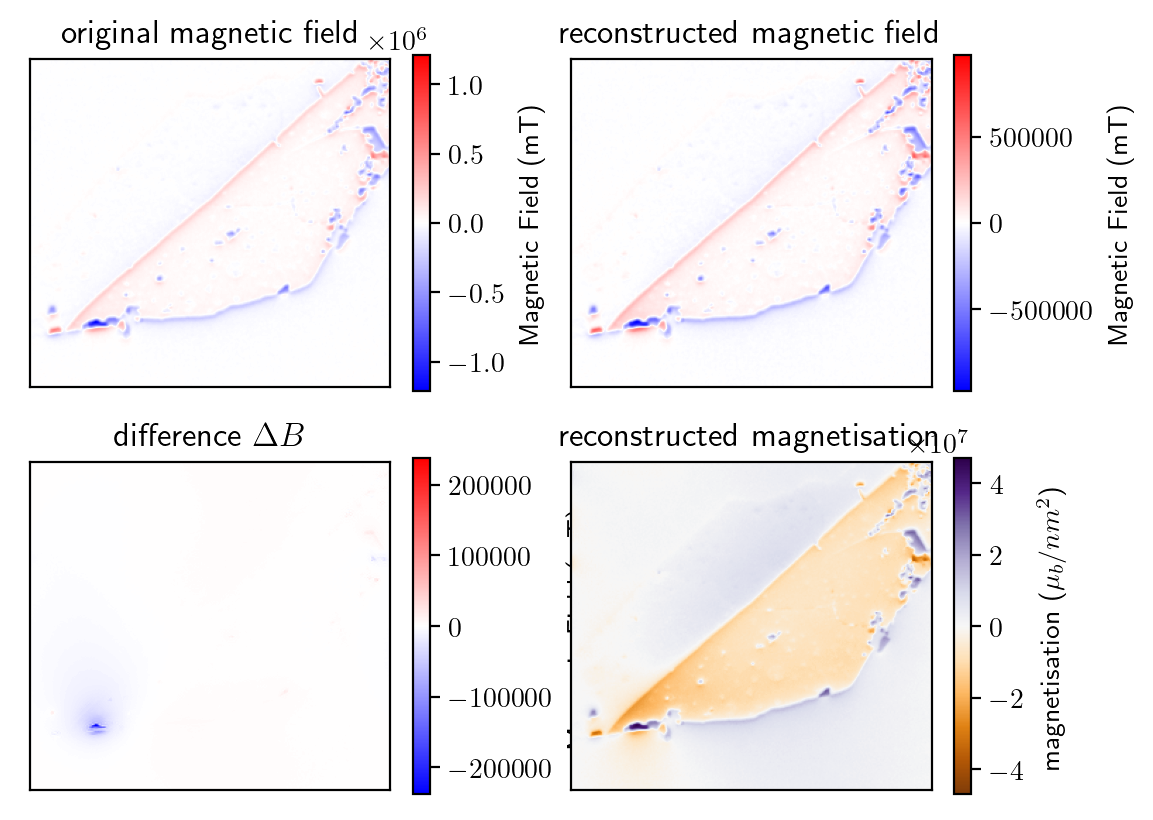

In [181]:
FittingMethod.plot_results()

# Now try recon in Fourier space

In [223]:
from magrec.method.FCNN import FCNN
from magrec.models.UniformMxyFspace import UniformMxyFspace as Mrecon

dataset5 = copy.deepcopy(dataset)
dataset5.target = dataset5.target*1e6

Model = Mrecon(dataset5, "MSE", m_theta = 0, m_phi = 0)
FittingMethod = FCNN(Model, dataset5)
FittingMethod.prepare_fit()

Number of sources: 1
Number of targets: 1
66048


In [224]:
FittingMethod.fit(n_epochs=100)

epoch     1 | loss on last mini-batch:  1.01e+01
epoch    11 | loss on last mini-batch:  1.01e+01
epoch    21 | loss on last mini-batch:  1.01e+01
epoch    31 | loss on last mini-batch:  1.01e+01
epoch    41 | loss on last mini-batch:  1.01e+01
epoch    51 | loss on last mini-batch:  9.53e+00
epoch    61 | loss on last mini-batch:  6.61e+00
epoch    71 | loss on last mini-batch:  4.92e+00
epoch    81 | loss on last mini-batch:  3.64e+00
epoch    91 | loss on last mini-batch:  2.94e+00


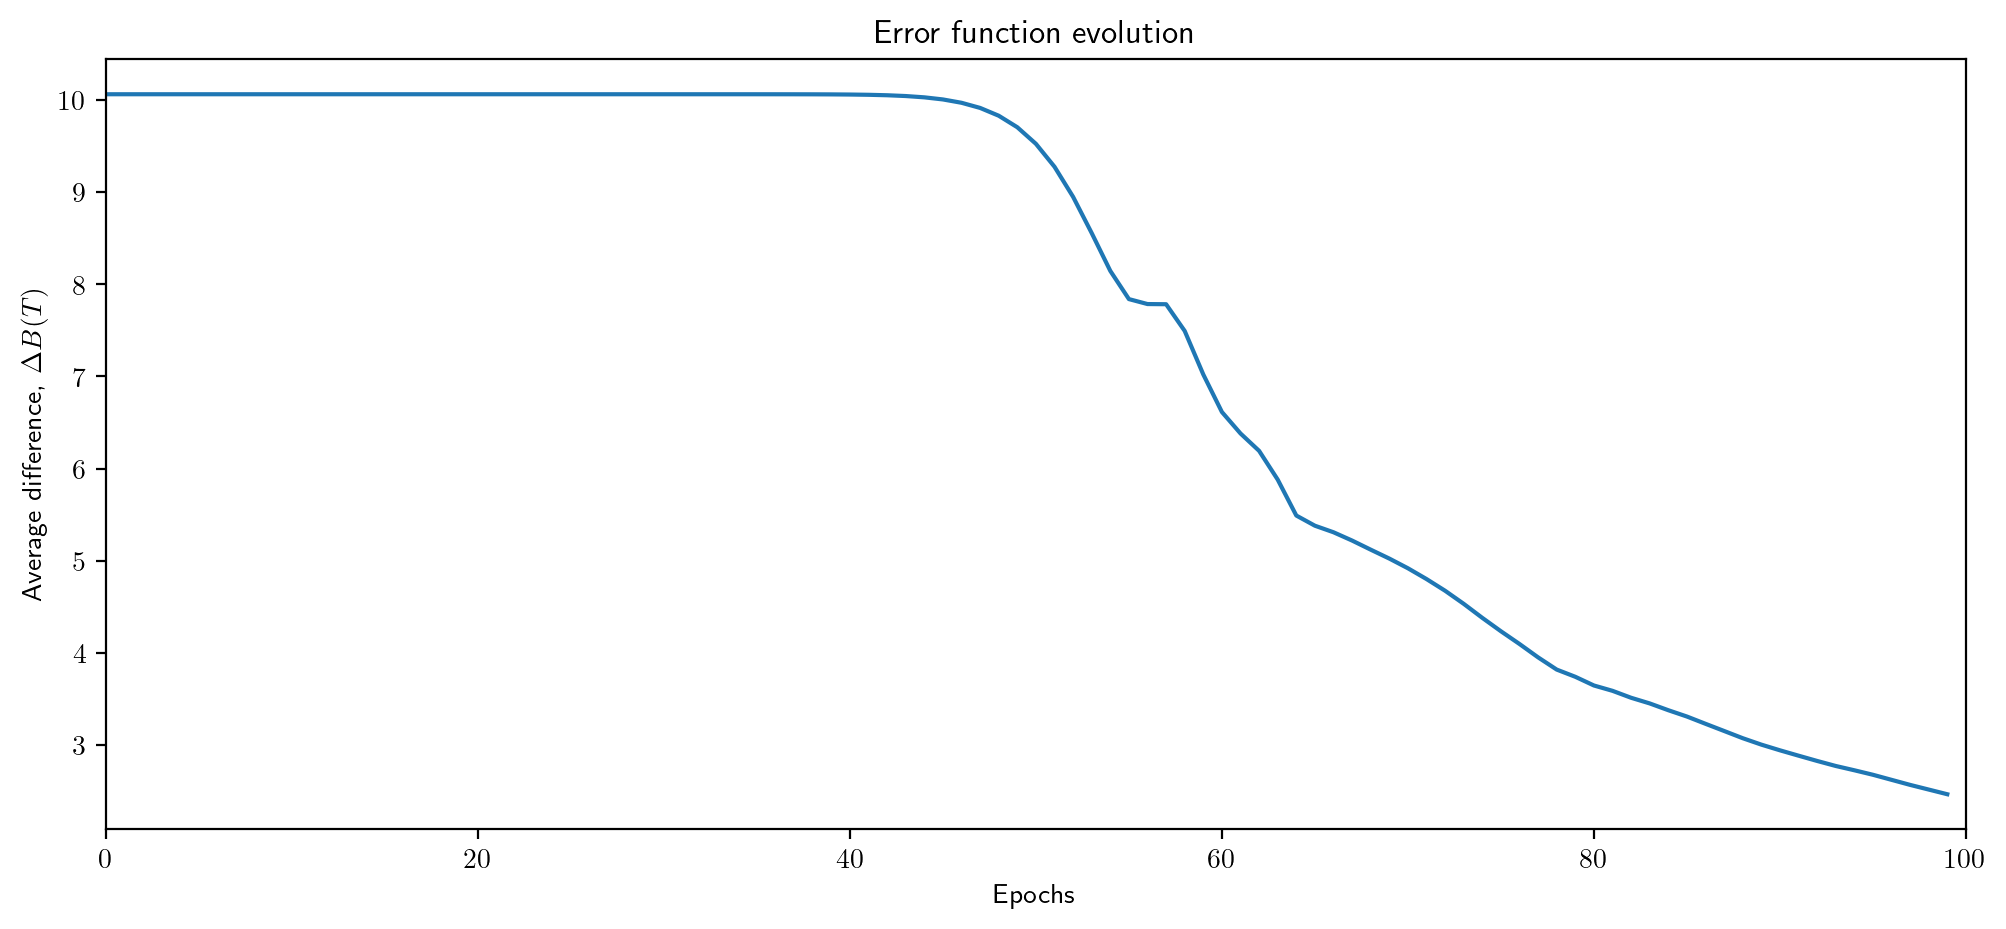

In [225]:
FittingMethod.plot_loss()

Removed the padding that was applied to the data


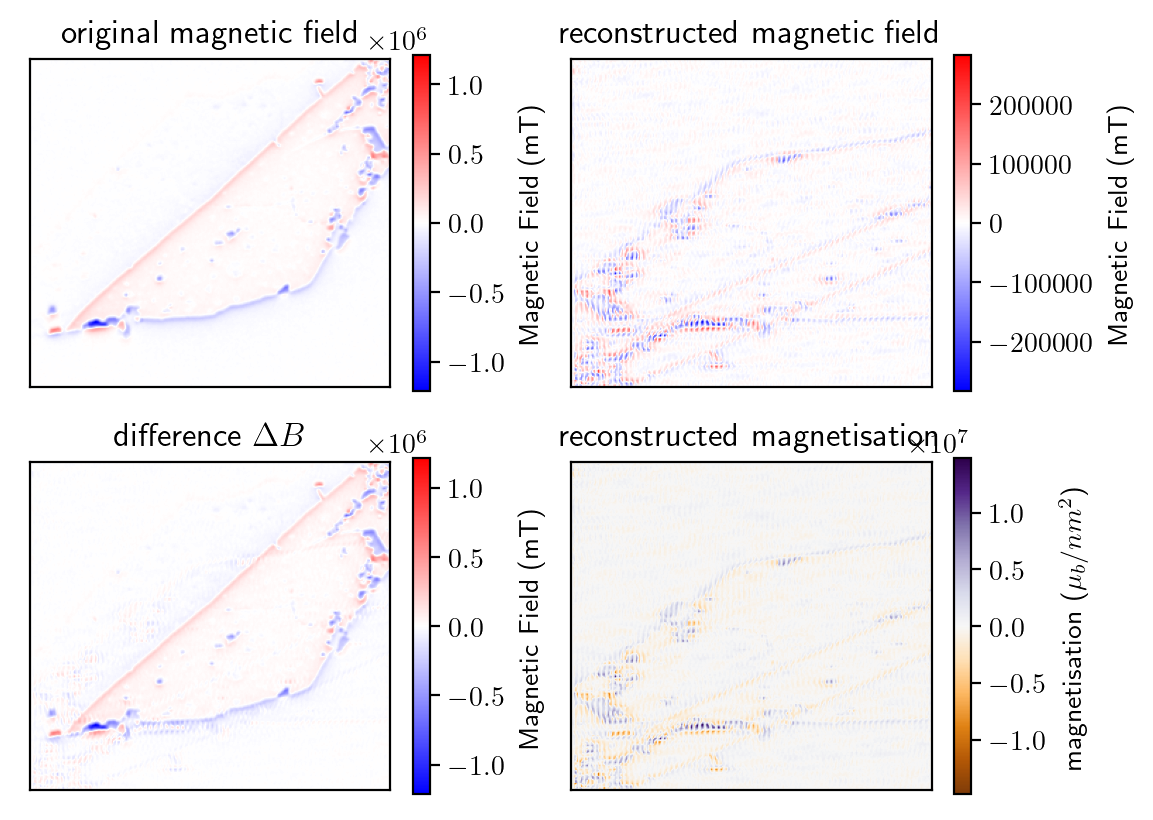

In [228]:
FittingMethod.extract_results()

FittingMethod.plot_results()

Text(0.5, 1.0, 'Difference')

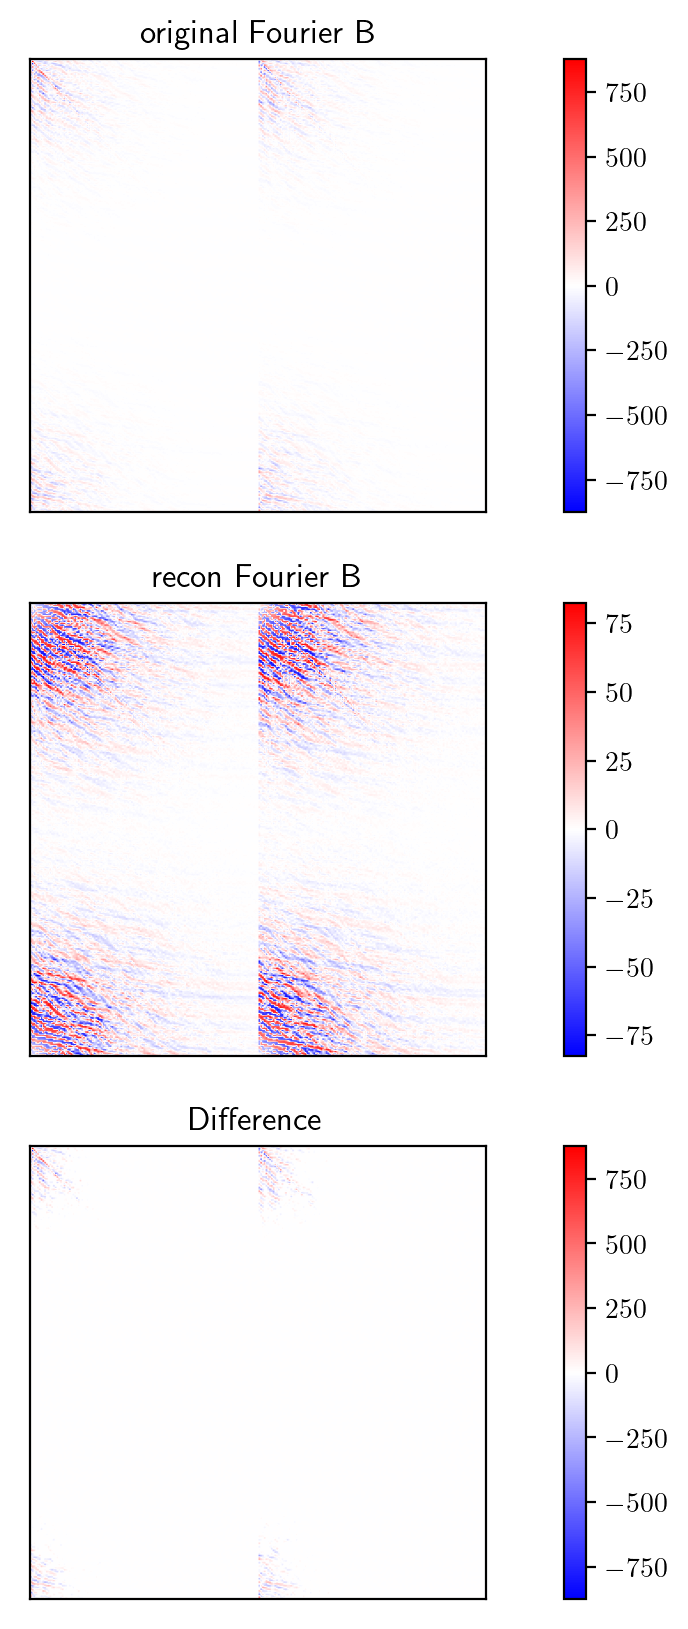

In [229]:
fig = plt.figure()
fig.set_size_inches(10, 10)
plt.subplot(3, 1, 1)
plot_data = FittingMethod.img_comp[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('original Fourier B')

plt.subplot(3, 1, 2)
plot_data = FittingMethod.final_b[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('recon Fourier B')

plt.subplot(3, 1, 3)
plot_data = FittingMethod.img_comp[0,0,::] - FittingMethod.final_b[0,0,::]
plot_range = abs(plot_data).max()
plt.imshow(plot_data, cmap="bwr", vmin=-plot_range, vmax=plot_range)
plt.xticks([])
plt.yticks([])
cb = plt.colorbar()
plt.title('Difference')



In [221]:
FittingMethod.final_b[0,0,::]

array([[ -0.        ,  -6.2427278 , -10.7397785 , ...,  -2.2756271 ,
         -0.85622257,   0.13363577],
       [-11.529959  ,   1.1379085 ,   6.8341413 , ...,   2.6627865 ,
         -1.903838  ,   0.2141381 ],
       [ 15.866942  , -16.934645  ,  18.854185  , ...,   2.132164  ,
          4.0869846 ,   2.3735259 ],
       ...,
       [  7.7800765 , -20.81428   , -13.10129   , ...,   1.6517527 ,
         -0.02683027,  -0.02098437],
       [ 16.154398  , -15.703379  , -17.700111  , ...,  -2.715921  ,
          0.21570557,  -2.4581296 ],
       [-12.120153  ,  10.612482  ,   0.14300919, ...,   0.54211056,
         -1.0244366 ,  -0.2789667 ]], dtype=float32)